In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
df = ...

In [ ]:
df

,subreddit,year,timeness
0,Conservative,2018,-0.273523
1,Conservative,2016,-0.110513
2,Conservative,2017,-0.096039
3,Conservative,2015,-0.050624
4,Conservative,2014,-0.046690
5,Conservative,2013,-0.032189
6,Conservative,2012,0.273523
7,democrats,2018,-0.153075
8,democrats,2017,-0.059341
9,democrats,2016,-0.047797


In [ ]:
import pickle
import pandas as pd
import json
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [ ]:
!pip install rbo

In [ ]:
METRICS_PATH = ...

In [ ]:
MODEL = "4096-voyage-01-truncating"

## Codigo

In [ ]:
"""
    This module generates d-ness scores from given dimension seed pairs
"""
from typing import TypeAlias, List, Sequence, Tuple

import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

Community: TypeAlias = str
CommunityPair: TypeAlias = Tuple[Community, Community]
Direction: TypeAlias = npt.NDArray[np.floating]
Index: TypeAlias = int
IndexList2D: TypeAlias = Tuple[List[int], List[int]]
Matrix: TypeAlias = npt.NDArray[np.floating]


def similarity_matrix(vectors: pd.DataFrame) -> Matrix:
    """Compute the cosine similarity pairwise between each row in vectors,
    but replace the principal diagonal with -inf.

    Args:
        vectors (pd.DataFrame): Input data.

    Returns:
        Matrix: Cosine similarity matrix.
    """
    cosine_sims = cosine_similarity(vectors)
    np.fill_diagonal(cosine_sims, float("-inf"))
    return cosine_sims


class DimensionGenerator:
    """A class to generate d-ness scores from seed pairs."""

    def __init__(
        self,
        vectors: pd.DataFrame,
        seeds: List[CommunityPair],
        names: List[Community],
        nn_n: int = 10,
        k: int = 10,
        chunk_size: int = 8,
    ):
        """Initialize a d-ness score generator with input data.

        Args:
            vectors (pd.DataFrame): Input data.

            seeds (List[CommunityPair]): List of dimension seed pairs.

            names (List[str]): List of dimension names.

            nn_n (int, optional): Nearest Neighbours Number of pairs to
            generate per community. Defaults to 10.

            k (int, optional): Number of directions used to
            create the dimension. Defaults to 10.

            chunk_size (int, optional): Processing chunk size for
            larger-than-memory data. Defaults to 8.
        """
        self.vectors = pd.DataFrame(
            normalize(vectors, norm="l2", axis=1), index=vectors.index
        )
        self.seeds = seeds
        self.names = names
        self.nn_n = min(len(vectors), nn_n)
        self.k = k
        self.chunk_size = chunk_size

    def value(self):
        """Calculate dimensions scores.

        Returns:
            pd.DataFrame: Dimensions scores DataFrame.
        """
        columns = {}
        dimensions = [self.augment_seed_direction(x) for x in self.seeds]
        for name, dimension in zip(self.names, dimensions):
            columns[name] = np.dot(
                self.vectors.to_numpy(), dimension / np.linalg.norm(dimension)
            )
        return pd.DataFrame(columns, index=self.vectors.index)

    def augment_seed_direction(self, seed_pair: CommunityPair) -> Direction:
        """Augment seed pair direction for a more robust representation of the dimension.

        All pairs are ranked based on the cosine similarity of their vector difference
        with the vector difference of the seed pair: cos(s2-s1, c2-c1). Additional pairs
        are then selected greedily.

        Args:
            seed_pair (CommunityPair): Dimension seed pair.

        Returns:
            Direction: Augmented dimension representation.
        """

        seed_direction = self.calculate_direction(seed_pair)
        sorted_directions = self.sorted_nn_directions(seed_direction)
        augmented_directions = self.augmentation_algorithm(
            seed_pair, seed_direction, sorted_directions
        )
        return np.sum(augmented_directions.to_numpy(), axis=0)

    def calculate_direction(self, community_pair: CommunityPair) -> Direction:
        """Calculate direction between community pair.

        Args:
            community_pair (CommunityPair): Input data.

        Returns:
            Direction: Direction between community pair.
        """
        return (
            self.vectors.loc[community_pair[1]].to_numpy()
            - self.vectors.loc[community_pair[0]].to_numpy()
        )

    def nearest_neighbours_directions(self) -> IndexList2D:
        """This is based on the aforementioned idea that we are looking for
        pairs of communities that are very similar, but differ only in the target concept.

        Returns:
            IndexList2D: the set of all pairs of communities (c1, c2) such that c1 != c2
            and c2 is one of the nn_n nearest neighbours to c1. (nn_n = 10 by default)
        """
        matrix = similarity_matrix(self.vectors)
        n_largest_values = np.partition(matrix, -self.nn_n, axis=1)[:, -self.nn_n]
        return np.where(matrix >= n_largest_values[:, np.newaxis])

    def sorted_nn_directions(self, seed_direction: Direction) -> pd.DataFrame:
        """Sort nearest neighbours directions by cosine similarity with seed direction

        Args:
            seed_direction (Direction): Seed direction

        Returns:
            pd.DataFrame: Sorted Nearest neighbours directions
        """

        nn_directions_indices = self.nearest_neighbours_directions()
        pair_names = self.nn_names(nn_directions_indices)
        seed_similarities = self.nn_similarities(nn_directions_indices, seed_direction)
        nn_directions = pd.DataFrame(
            index=pd.MultiIndex.from_tuples(pair_names),
            data=seed_similarities,
            columns=["similarity"],
        )
        return nn_directions.sort_values("similarity", ascending=False)

    def nn_similarities(
        self,
        nn_directions_indices: IndexList2D,
        seed_direction: Direction,
    ) -> List[float]:
        """Calculate nearest neighbours cosine similarity with seed direction

        Args:
            nn_directions_indices (IndexList2D): List of nearest neighbours indices
            seed_direction (Direction): Seed direction

        Returns:
            List[float]: Nearest neighbours cosine similarity with seed direction
        """
        # 1-D Vector. No me queda claro por que hace producto interno en vez de cosine similarity
        # los vectores no estan normalizados, asi que no son equivalentes
        seed_similarities = []
        c1_indices, c2_indices = nn_directions_indices
        n_rows = len(c1_indices)
        for i in range(0, n_rows, self.chunk_size):
            k = min(i + self.chunk_size, n_rows)
            chunk_xs1 = self.vectors.to_numpy()[c1_indices[i:k]]
            chunk_xs2 = self.vectors.to_numpy()[c2_indices[i:k]]

            pairs_difference = chunk_xs2 - chunk_xs1

            similarities = np.dot(pairs_difference, seed_direction)
            seed_similarities.extend(similarities)

        return seed_similarities

    def nn_names(self, nn_directions_indices: IndexList2D) -> List[CommunityPair]:
        """Retrieve names of nearest neighbours pairs

        Args:
            nn_directions_indices (IndexList2D): List of nearest neighbours indices

        Returns:
            List[CommunityPair]: List of community pairs
        """
        comm_names = list(self.vectors.index)
        return [
            (comm_names[c1], comm_names[c2]) for c1, c2 in zip(*nn_directions_indices)
        ]

    def augmentation_algorithm(
        self,
        seed_pair: CommunityPair,
        seed_direction: Direction,
        sorted_directions: pd.DataFrame,
    ) -> pd.DataFrame:
        """Seed augmentation algorithm.

        The most similar pair to the original seed pair
        that has no overlap in communities with the seed pair or any of the previously
        selected pairs is selected, and this process is repeated until k - 1
        additional pairs are selected, which results in the k pairs used to create
        the dimension.

        Args:
            seed_pair (CommunityPair): Dimension seed pair.
            seed_direction (Direction): Seed pair direction.
            sorted_directions (pd.DataFrame): DESC Sorted nearest neighbours directions.

        Returns:
            pd.DataFrame: Augmented seed pair dimension directions.
        """
        ban_list = list(seed_pair)

        i = -1  # filter out seed pair
        while i < len(sorted_directions) and i < self.k + 1:
            ban_list.extend(sorted_directions.index[i])

            c1 = sorted_directions.index.get_level_values(0)
            c2 = sorted_directions.index.get_level_values(1)
            sorted_directions = sorted_directions[
                (np.arange(0, len(sorted_directions)) <= i)
                | ((~c1.isin(ban_list)) & (~c2.isin(ban_list)))
            ]

            i += 1

        indices_to_calc = sorted_directions.index[:k].tolist()
        pairs_difference = [
            self.vectors.loc[c2] - self.vectors.loc[c1] for c1, c2 in indices_to_calc
        ]

        sorted_directions = pd.DataFrame(
            index=pd.MultiIndex.from_tuples([seed_pair] + indices_to_calc),
            data=np.concatenate([[seed_direction], pairs_difference]),
        )
        return sorted_directions.iloc[0 : self.k]



In [ ]:
def arxiv_waller_scores():
    return {
        "democrats": -0.345948606707049,
        "EnoughLibertarianSpam": -0.322594981636269,
        "hillaryclinton": -0.3027931218773805,
        "progressive": -0.2994712557588187,
        "BlueMidterm2018": -0.2977831668625458,
        "EnoughHillHate": -0.2933539740564371,
        "Enough_Sanders_Spam": -0.2929483022563205,
        "badwomensanatomy": -0.2926874460908718,
        "racism": -0.2921137058022828,
        "GunsAreCool": -0.290219904193626,
        "Christians": 0.2607635855569176,
        "The_Farage": 0.2658256024989052,
        "new_right": 0.2697649330292293,
        "conservatives": 0.2743712713632447,
        "metacanada": 0.2865165930755363,
        "Mr_Trump": 0.2895610652703748,
        "NoFapChristians": 0.2934370114397415,
        "TrueChristian": 0.3142461533194396,
        "The_Donald": 0.3351316374970578,
        "Conservative": 0.444171415963574,
    }


def arxiv_waller_ranking():
    return list(arxiv_waller_scores().keys())

In [ ]:
import statistics
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rbo
from scipy import stats
import seaborn as sns
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    roc_auc_score,
)


def leaning_right(z_score):
    return z_score > 1


def leaning_left(z_score):
    return z_score < -1


def calc_rbo(predicted_ranking, true_ranking, p):  # TODO: Seleccionar un p
    return rbo.RankingSimilarity(true_ranking, predicted_ranking).rbo(p=p)


def calc_mean(fst_half_score, snd_half_score):
    return statistics.mean([fst_half_score, snd_half_score])


def split_and_reverse(n, ranking):
    half_ranking = ranking[n:]
    half_ranking.reverse()
    return half_ranking


def dem_rep_field():
    return "dem_rep"


class Ranking:
    @classmethod
    def from_pandas(cls, score_data, field=dem_rep_field(), **kwargs):
        score_data = score_data.to_dict(orient="dict")[field]
        return cls(score_data, **kwargs)

    def __init__(
        self, ranking: dict, p: int = 1.0, ground_truth: dict = arxiv_waller_scores()
    ):
        """Creates a Ranking Comparison object

        Args:
            ranking (dict): Observed ranking scores
            p (int, optional): p parameter for the RBO metrics. Defaults to 1.0.
            ground_truth (dict, optional): Ground truth ranking scores. Defaults to arxiv_waller_scores().
        """
        self.ranking = ranking
        self.ground_truth = ground_truth
        self.p = p

    def compare_ranking(self):
        classification_metrics = self.evaluate_classification_metrics()
        ranking_metrics = self.evaluate_ranking_metrics()
        plots = self.generate_plots()

        Metrics = namedtuple("Metrics", "classification_metrics ranking_metrics plots")
        return Metrics(classification_metrics, ranking_metrics, plots)

    def generate_plots(self):
        return {
            "bump": self.bump_plot(),
            "kde": self.kde_plot(),
            "violin": self.violin_plot(),
            "bean": self.bean_plot(),
            "roc_auc": self.roc_auc_plot(),
        }

    def evaluate_ranking_metrics(self):
        return {
            "Kendall Tau": [self.kendall_score()],
            "Classic RBO": [self.rbo_score()],
            "Two way RBO": [self.two_way_rbo_score()],
            "H&H RBO": [self.half_and_half_rbo_score()],
            "AUC ROC": [self.roc_auc_score()],
        }

    def evaluate_classification_metrics(self):
        return {
            "Precision": self.precision_score(),
            "Recall": self.recall_score(),
            "F1 Score": self.f1_score(),
        }

    # Classification metrics

    def z_score_for(self, subreddit):
        return (self.score_for(subreddit) - self.mean_score()) / self.sd_score()

    def z_scores(self):
        return self.z_scores_for_subreddits(self.subreddits())

    def z_scores_for_subreddits(self, subreddits):
        return [self.z_score_for(s) for s in subreddits]

    def score_for(self, subreddit):
        return self.ranking[subreddit]

    def scores(self):
        return self.scores_for_subreddits(self.subreddits())

    def scores_for_subreddits(self, subreddits):
        return [self.score_for(s) for s in subreddits]

    def party_scores(self, party_label):
        partisans = self.subreddits_of_partisan(party_label)
        return np.array(self.z_scores_for_subreddits(partisans))

    def democrats_scores(self):
        return self.party_scores(democrat_label())

    def conservatives_scores(self):
        return self.party_scores(conservative_label())

    def subreddits(self):
        return self.ranking.keys()

    def mean_score(self):
        return statistics.mean(self.scores())

    def sd_score(self):
        return statistics.stdev(self.scores())

    def classification_score(self, scoring_function):
        scores = scoring_function(
            self.ground_truth(),
            self.predict_political_party(),
            labels=political_party_labels(),
            average=None,
        )
        return {label: scores[i] for i, label in enumerate(political_party_labels())}

    def precision_score(self):
        return self.classification_score(precision_score)

    def recall_score(self):
        return self.classification_score(recall_score)

    def f1_score(self):
        return self.classification_score(f1_score)

    def ground_truth(self):
        return [
            waller_political_party_label_for(subreddit)
            for subreddit in self.subreddits()
        ]

    def predict_political_party(self):
        predicted_labels = []
        for subreddit in self.subreddits():
            z_score = self.z_score_for(subreddit)
            if leaning_right(z_score):
                predicted_labels.append(conservative_label())
            elif leaning_left(z_score):
                predicted_labels.append(democrat_label())
            else:
                predicted_labels.append(neutral_label())

        return predicted_labels

    # Ranking comparison metrics

    def kendall_score(self):
        """
        -1 = negatively correlated,
         0 = random,
         1 = positively correlated
        """
        predicted_ranking = self.subreddits_sorted_by_score_desc()
        true_ranking = self.arxiv_waller_ranking()
        x = [true_ranking.index(item) + 1 for item in predicted_ranking]
        y = [i for i in range(1, len(true_ranking) + 1)]
        res = stats.kendalltau(x, y)
        return res.statistic

    def rbo_score(self):
        """
        0 = disjoint,
        1 = identical
        """
        predicted_ranking = self.subreddits_sorted_by_score_desc()
        true_ranking = self.arxiv_waller_ranking()
        res = calc_rbo(predicted_ranking, true_ranking, self.p)
        return res

    def half_and_half_rbo_score(self):
        predicted_ranking = self.subreddits_sorted_by_score_desc()
        true_ranking = self.arxiv_waller_ranking()
        n = len(predicted_ranking) // 2

        fst_half_score = calc_rbo(predicted_ranking[:n], true_ranking[:n], self.p)
        snd_half_score = calc_rbo(
            split_and_reverse(n, predicted_ranking),
            split_and_reverse(n, true_ranking),
            self.p,
        )
        return calc_mean(fst_half_score, snd_half_score)

    def two_way_rbo_score(self):
        predicted_ranking = self.subreddits_sorted_by_score_desc()
        true_ranking = self.arxiv_waller_ranking()
        desc_way_score = calc_rbo(predicted_ranking, true_ranking, self.p)

        predicted_ranking.reverse()
        true_ranking.reverse()
        asc_way_score = calc_rbo(predicted_ranking, true_ranking, self.p)
        return calc_mean(desc_way_score, asc_way_score)

    def t_student_p_value(self):
        p_val_t = stats.ttest_ind(self.conservatives_scores(), self.democrats_scores())[
            1
        ]
        return p_val_t

    def roc_auc_score(self):
        standardized_scores = np.array(self.z_scores())
        probabilities = 1 / (1 + np.exp(-standardized_scores))
        labels = [
            1 if label == conservative_label() else 0
            for label in self.subreddits_party_labels()
        ]
        roc_auc = roc_auc_score(labels, probabilities)
        return roc_auc

    def subreddits_sorted_by_score_desc(self):
        return sorted(self.subreddits(), key=lambda k: self.score_for(k))

    def arxiv_waller_ranking(self):
        return [s for s in self.ground_truth if s in self.subreddits()]

    # Plots

    def bump_plot(self):
        predicted_ranking = self.subreddits_sorted_by_score_desc()
        waller_ranking = self.arxiv_waller_ranking()
        rankings = [
            {
                "Model": ["waller", "fasttext"],
                "Rank": [i + 1, predicted_ranking.index(subreddit) + 1],
                "Subreddit": subreddit,
            }
            for i, subreddit in enumerate(waller_ranking)
        ]
        with sns.plotting_context("paper"):
            return bump_chart(rankings, len(waller_ranking))

    def violin_plot(self, title=None):
        df = pd.DataFrame(
            {
                "dem_rep": self.scores(),
                "subreddit": self.subreddits(),
                "political party": self.subreddits_party_labels(),
            }
        )
        with sns.plotting_context("paper"):
            fig, axis = plt.subplots()
            sns.violinplot(
                data=df,
                y="dem_rep",
                x="political party",
                order=[democrat_label(), conservative_label()],
                inner="stick",
                ax=axis,
            )
            axis.set_title(title)
            return fig

    def kde_plot(self):
        df = pd.DataFrame(
            {
                "dem_rep": self.scores(),
                "subreddit": self.subreddits(),
                "political party": self.subreddits_party_labels(),
            }
        )
        with sns.plotting_context("paper"):
            fig, axis = plt.subplots()
            sns.kdeplot(data=df, x="dem_rep", hue="political party", fill=True, ax=axis)
            return fig

    def bean_plot(self):
        df = pd.DataFrame(
            {
                "dem_rep": self.scores(),
                "subreddit": self.subreddits(),
                "political_party": self.subreddits_party_labels(),
                "political party": [""] * len(self.scores()),
            }
        )
        with sns.plotting_context("paper"):
            fig, axis = plt.subplots()
            sns.violinplot(
                data=df,
                x="political party",
                y="dem_rep",
                hue="political_party",
                split=True,
                inner="stick",
                ax=axis,
            )
            return fig

    def roc_auc_plot(self):
        # Genera dos distribuciones, una para la "clase" positiva y otra para la negativa
        negative = self.democrats_scores()
        positive = self.conservatives_scores()

        # Junta los datos en un solo arreglo y crea las etiquetas correspondientes
        data = np.concatenate([positive, negative])
        labels = np.concatenate([np.ones(len(positive)), np.zeros(len(negative))])

        # Calcula la curva ROC
        fpr, tpr, _ = roc_curve(labels, data)
        roc_auc = auc(fpr, tpr)

        with sns.plotting_context("paper"):
            fig, axis = plt.subplots()
            axis.plot(
                fpr, tpr, color="darkorange", label="Curva ROC (area = %0.2f)" % roc_auc
            )
            axis.plot(
                [0, 1], [0, 1], color="navy", linestyle="--"
            )  # línea diagonal para comparación
            axis.set_xlim([0.0, 1.0])
            axis.set_ylim([0.0, 1.05])
            axis.set_xlabel("Tasa de Falsos Positivos")
            axis.set_ylabel("Tasa de Verdaderos Positivos")
            axis.set_title("Curva ROC de las distribuciones")
            axis.legend(loc="lower right")
            return fig

    def subreddits_party_labels(self):
        return [waller_political_party_label_for(s) for s in self.subreddits()]

    def subreddits_of_partisan(self, party_label):
        return [
            s
            for s in self.subreddits()
            if waller_political_party_label_for(s) == party_label
        ]


def democrat_label():
    return "democrat"


def conservative_label():
    return "conservative"


def political_party_labels():
    return [democrat_label(), neutral_label(), conservative_label()]


def neutral_label():
    return "neutral"


def waller_political_party_label_for(subreddit):
    score = arxiv_waller_scores()[subreddit]
    if score < 0:
        return democrat_label()
    return conservative_label()


def bump_chart(elements, n, title="Comparison of Models on Subreddits"):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    for element in elements:
        ax.plot(
            element["Model"],
            element["Rank"],
            "o-",
            markerfacecolor="white",
            linewidth=3,
        )
        ax.annotate(
            element["Subreddit"],
            xy=("Cohere", element["Rank"][1]),
            xytext=(1.01, element["Rank"][1]),
            fontsize=14,
        )

    plt.gca().invert_yaxis()
    plt.yticks([i for i in range(1, n + 1)], fontsize=14)

    ax.set_xlabel("Model")
    ax.set_ylabel("Rank")
    ax.set_title(title)

    for spine in ax.spines.values():
        spine.set_visible(False)

    return fig

## Descargar embeddings

In [ ]:
!unzip -u /content/drive/MyDrive/...

Archive:  /content/drive/MyDrive/BIICC/biicc-franco/embeddings/4096-voyage-01-truncating.zip
  inflating: kaggle/working/embeddings-2012-4096-voyage-01.pkl  
  inflating: kaggle/working/embeddings-2013-4096-voyage-01.pkl  
  inflating: kaggle/working/embeddings-2014-4096-voyage-01.pkl  
  inflating: kaggle/working/embeddings-2015-4096-voyage-01.pkl  
  inflating: kaggle/working/embeddings-2016-4096-voyage-01.pkl  
  inflating: kaggle/working/embeddings-2017-4096-voyage-01.pkl  
  inflating: kaggle/working/embeddings-2018-4096-voyage-01.pkl  


In [ ]:
def read_pickle(year, path=None):
  with open(path, "rb") as fIn:
      stored_data = pickle.load(fIn)
      subreddits = stored_data['subreddits']
      embeddings = stored_data['embeddings']
  return pd.DataFrame(embeddings, index=subreddits, columns=range(len(embeddings[0])) )

## Generacion de Scores

In [ ]:
seeds = [("democrats", "Conservative")]
names = ['dem_rep']
datasets = [MODEL]
results = {}
for name in names:
  results[name] = {}
  for dataset in datasets:
    results[name][dataset] = {}

In [ ]:
def get_metrics(scores, field, p, ground_truth=None):
  scores = scores[scores.index.isin(arxiv_waller_scores())]
  ranking = Ranking.from_pandas(scores, field=field, p=p)
  return ranking.evaluate_ranking_metrics()

In [ ]:
for dataset in datasets:
  for year in range(2012, 2019):
    vectors = read_pickle(year)
    generator = DimensionGenerator(vectors, seeds, names)
    scores = generator.value()
    for name in names:
      results[name][dataset][year] = get_metrics(scores, name, 2/3)

In [ ]:
with open(METRICS_PATH / f"{MODEL}.json", "w") as file:
    json.dump(results["dem_rep"], file)

## Cargar Metricas

In [ ]:
metrics = {}

In [ ]:
for file in METRICS_PATH.glob("*truncating.json"):
  with open(file, "r") as f:
    model_metrics = json.load(f)
    metrics.update(model_metrics)

In [ ]:
for file in METRICS_PATH.glob("*centroid.json"):
  with open(file, "r") as f:
    model_metrics = json.load(f)
    metrics.update(model_metrics)

In [ ]:
nl4ai_models = {
    "cohere": "512-cohere-embed-english-v2.0-truncating.json",
    "fasttext_pretrained": "fasttext_pretrained_embeddings.json",
    "fasttext_raw": "fasttext_raw_embeddings.json",
    "fasttext_truncated": "fasttext_truncated_embeddings.json"
    }

In [ ]:
for model in nl4ai_models:
  with open(METRICS_PATH / nl4ai_models[model], 'r') as f:
    metrics.update(json.load( f))

In [ ]:
data = {
    'model': [],
    'year': [],
    'Kendall Tau': [],
    'Classic RBO': [],
    'Two way RBO': [],
    'H&H RBO': [],
    'AUC ROC': []
}

In [ ]:
for model, model_metrics in metrics.items():
  for year, annual_metrics in model_metrics.items():
    data['year'].append(year)
    data['model'].append(model.replace('_embeddings', ''))
    for metric, value in annual_metrics.items():
        if metric in data:
          data[metric].append(*value)

In [ ]:
df = pd.DataFrame(data)

## Random baseline

In [ ]:
random_path = ...

In [ ]:
with open(random_path, 'r') as f:
  random_mean = json.load(f)

## Graficos

In [ ]:
metrics = ['Classic RBO', 'H&H RBO', 'Two way RBO', 'Kendall Tau']

In [ ]:
sns.set_style("whitegrid")

In [ ]:
def df_for_facet_grid(df):
    value_column = pd.Series([], name='value', dtype=float)
    metric_column = pd.Series([], name='metric', dtype=str)
    model_column = pd.Series([], name='model', dtype=str)
    year_column = pd.Series([], name='year', dtype=int)

    for metric in metrics:
        value_column = pd.concat([value_column, df[metric]])
        metric_column = pd.concat([metric_column, pd.Series([metric]*len(df[metric]), name='metric')])
        model_column = pd.concat([model_column, df.model])
        year_column = pd.concat([year_column, df.year])

    df = pd.DataFrame({
        'year': year_column,
        'model': model_column,
        'value': value_column,
        'metric': metric_column
    }).sort_values(['year', 'model'])
    return df

In [ ]:
#hue_order = [MODEL, 'Cohere']
#hue_order = ['Cohere','truncated', 'pretrained', 'raw']
hue_order=None

In [ ]:
hue_order = [
  'Cohere',
  '512-all-MiniLM-L6-v2-truncating',
  '512-jina-embeddings-v2-small-en-truncating',
  '1024-jina-embeddings-v2-small-en-truncating',
  '512-jina-embeddings-v2-base-en-truncating',
  '1024-jina-embeddings-v2-base-en-truncating',
  "4096-voyage-lite-01-truncating",
  "4096-voyage-01-truncating",

  '512-fastchat-t5-3b-v1.0-truncating'
  '256-all-MiniLM-L6-v2-centroid'
]

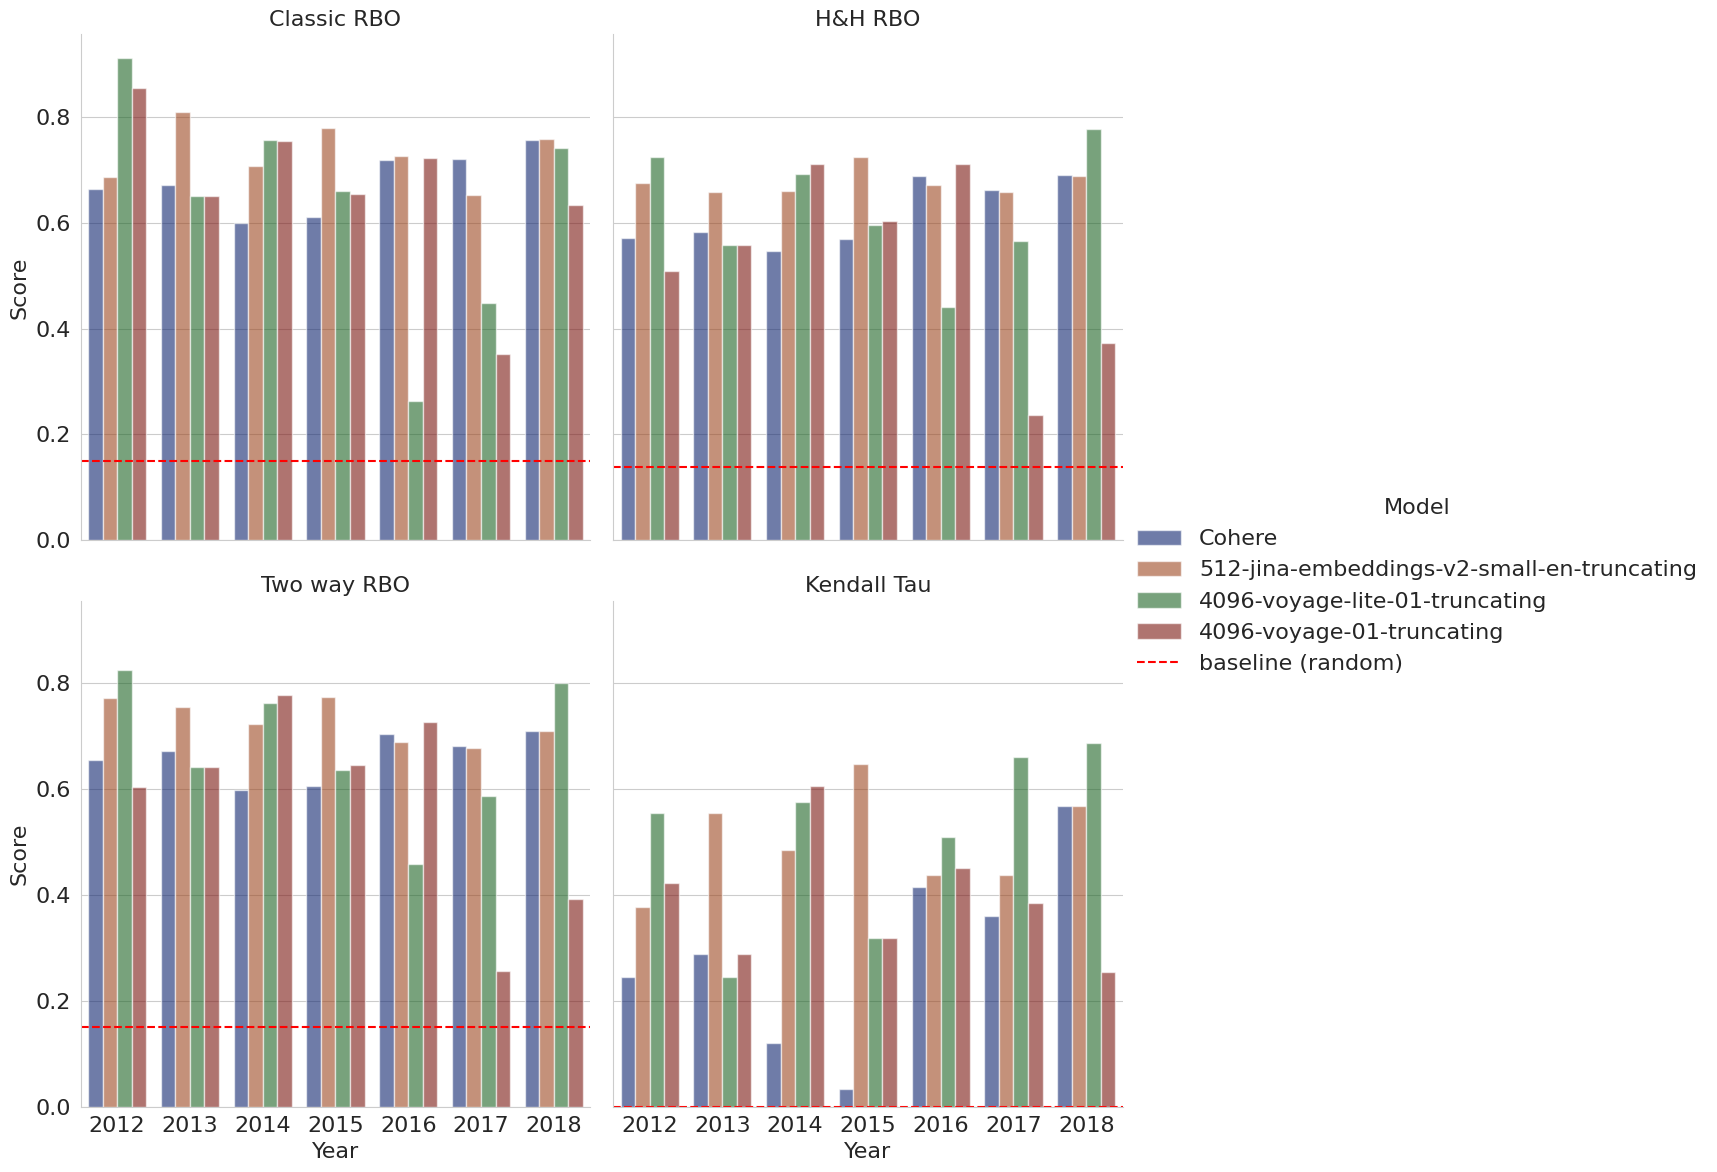

In [ ]:
def ranking_metrics(df, palette="dark"):
  matplotlib.rcParams.update({'font.size': 16})


  g = sns.FacetGrid(df, col="metric", height=6, col_order=metrics, col_wrap=2)
  g.map_dataframe(sns.barplot, x="year", y="value", hue="model",hue_order=hue_order, palette=palette, alpha=0.6)
  g.set_axis_labels("Year", "Score")
  g.set_titles("{col_name}")


  def add_axhline(data, **kwargs):
      metric = next(kwargs['metric'])
      plt.axhline(y=random_mean[metric], color='red', linestyle='--', label='baseline (random)')

  g.map_dataframe(add_axhline, metric=iter(metrics))
  g.add_legend()
  g.legend.set_title("Model")

  plt.savefig('grouped_plot.png')
ranking_metrics(df_for_facet_grid(df))

In [ ]:
def plot(metric, df, bottom=None, palette="dark"):
    g = sns.catplot(
            data=df, kind="bar",
            x="year", y=metric, hue="model", hue_order=hue_order, palette=palette, alpha=.6, height=6, legend=False
        )
    line = plt.axhline(y=random_mean[metric], color='red', linestyle='--', label='baseline (random)')
    g._legend_data['baseline (random)'] = line
    g.add_legend()

    g.ax.set_ylim(bottom=bottom)

    g.legend.set_title("Model")
    plt.title(f"Models comparison")
    plt.subplots_adjust(top=0.9)

    plt.savefig(f"{metric}.png")

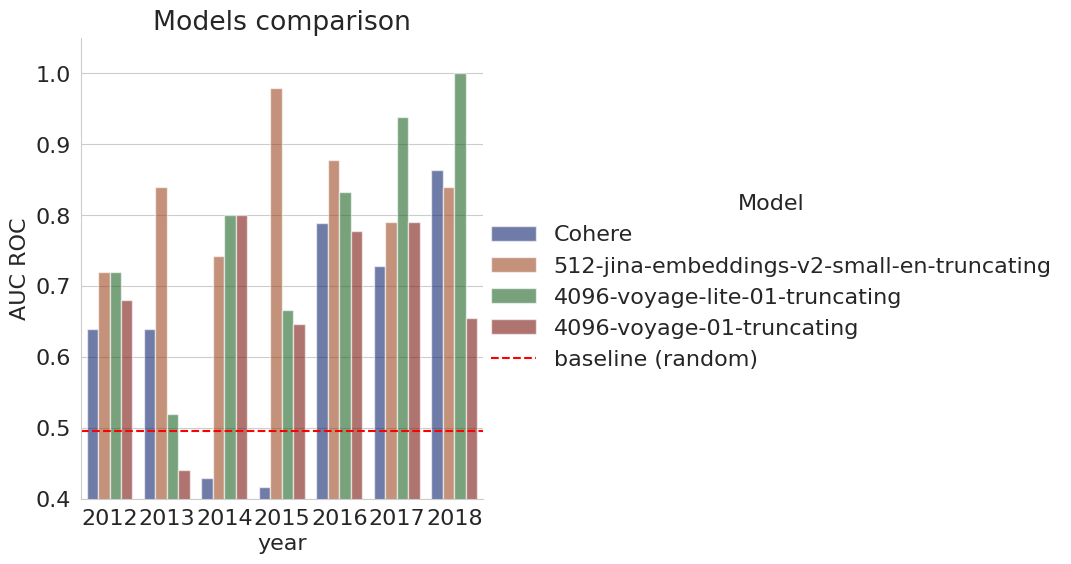

In [ ]:
plot('AUC ROC', df, bottom=0.4, palette="dark")

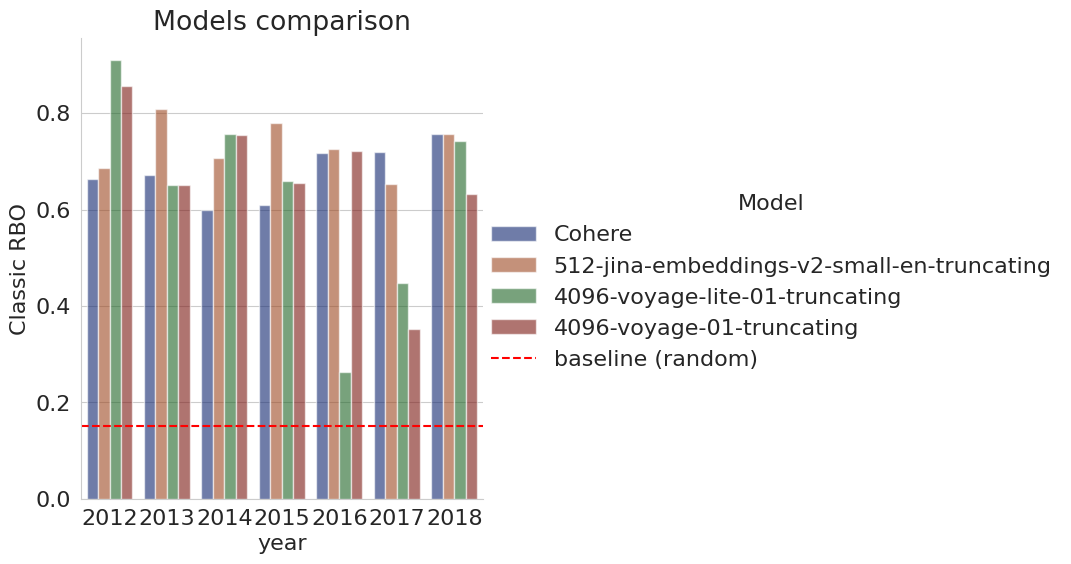

In [ ]:
plot('Classic RBO', df, palette="dark")

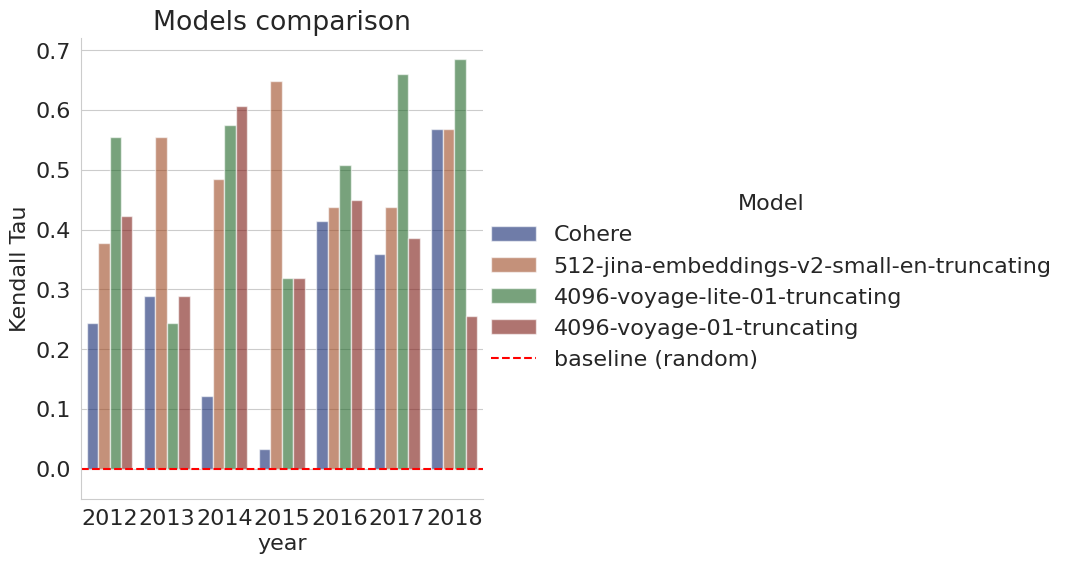

In [ ]:
plot('Kendall Tau', df, bottom=-0.05, palette="dark")